In [1]:
!pip install efficientnet==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import the tensorflow.keras version of efficientnet
from efficientnet import tfkeras as efficientnet
import matplotlib.pyplot as plt

In [3]:

# when running on Colab, this will download the dataset and save into runtime first
import sys
if 'google.colab' in sys.modules:
    !wget https://github.com/KiweeEu/transfer-learning-demo/raw/master/data/flowers.h5 -P ./data

flowers_data = h5py.File('./data/flowers.h5', 'r')
images_data = flowers_data['images'][:]
labels_data = flowers_data['labels'][:]

--2024-05-31 12:06:44--  https://github.com/KiweeEu/transfer-learning-demo/raw/master/data/flowers.h5
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/KiweeEu/transfer-learning-demo/master/data/flowers.h5 [following]
--2024-05-31 12:06:44--  https://raw.githubusercontent.com/KiweeEu/transfer-learning-demo/master/data/flowers.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10324178 (9.8M) [application/octet-stream]
Saving to: ‘./data/flowers.h5’

flowers.h5          100%[===================>]   9.85M  --.-KB/s    in 0.08s   

2024-05-31 12:06:45 (123 MB/s) - ‘./data/flowers.h5’ saved [10324178/

In [4]:

print(f'Images data shape: {images_data.shape}')
print(f'Labels data shape: {labels_data.shape}')
print(f'Images data min: {np.min(images_data)}, max: {np.max(images_data)}')
print(f'Images data type: {images_data.dtype}')
print(f'Labels data type: {labels_data.dtype}')
print(f'Unique labels: {np.unique(labels_data)}')
print(f'Number of unique labels: {len(np.unique(labels_data))}')

Images data shape: (210, 128, 128, 3)
Labels data shape: (210,)
Images data min: 0, max: 255
Images data type: uint8
Labels data type: uint8
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10


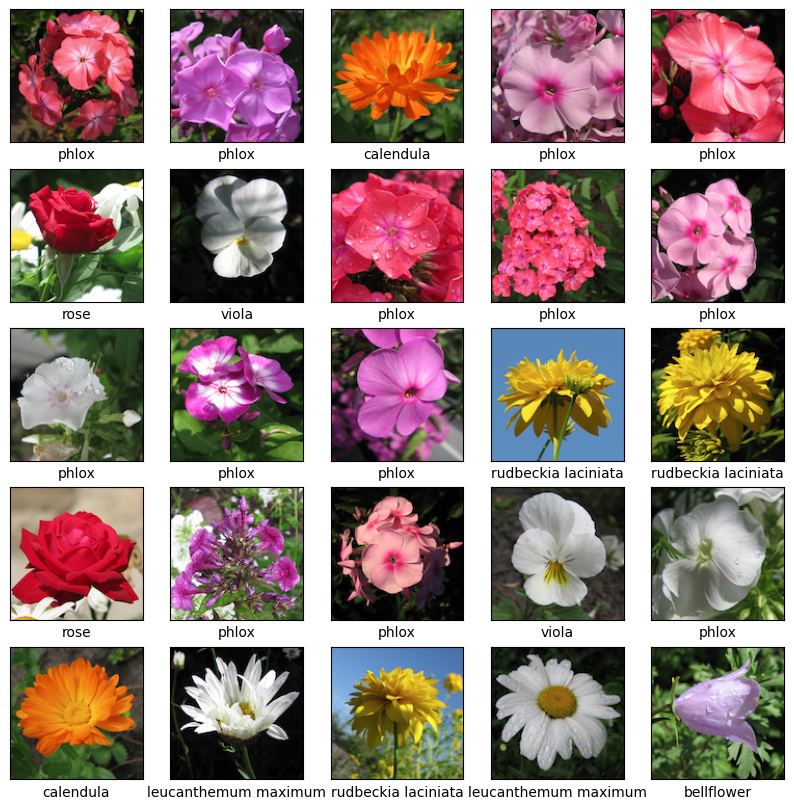

In [5]:

# Names of flower species are just for visualisation
flower_names = [
 'phlox','rose','calendula','iris','leucanthemum maximum',
    'bellflower','viola','rudbeckia laciniata','peony','aquilegia'
]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_data[i])
    plt.xlabel(flower_names[labels_data[i]])
plt.show()

In [6]:
# Set a seed for reproducibility
seed = 1
def shuffle(a, b, seed=None):
    rand = np.random.RandomState(seed)
    p = rand.permutation(a.shape[0])
    return a[p], b[p]

x_data, y_data = shuffle(images_data, labels_data, seed=seed)

# Use a larger portion of the data for training (e.g., 80% for training and 20% for validation)
split_ratio = 0.8
split_idx = int(split_ratio * x_data.shape[0])
x_train, y_train = x_data[:split_idx], y_data[:split_idx]
x_val, y_val = x_data[split_idx:], y_data[split_idx:]

In [7]:
# Create ImageDataGenerator instances with data augmentation for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

# Create iterators
train_iterator = train_datagen.flow(x_train, y_train, batch_size=30)
val_iterator = val_datagen.flow(x_val, y_val, batch_size=105)

In [8]:
# Define the custom CNN model
def create_custom_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')
    ])
    return model
# Create the custom CNN model
input_shape = (224, 224, 3)  # Example input shape, replace with your actual data shape
cnn_model = create_custom_cnn_model(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [9]:
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load MobileNet and EfficientNet models without top layers
mobilenet_base = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_base = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base models
mobilenet_base.trainable = False
efficientnet_base.trainable = False

# Define the model
input_layer = tf.keras.layers.Input(shape=input_shape)

# Pass the input through MobileNet
mobilenet_features = mobilenet_base(input_layer)
mobilenet_features = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_features)

# Pass the input through EfficientNet
efficientnet_features = efficientnet_base(input_layer)
efficientnet_features = tf.keras.layers.GlobalAveragePooling2D()(efficientnet_features)

# Pass the input through custom CNN model
custom_features = cnn_model(input_layer)
custom_features = tf.keras.layers.GlobalAveragePooling2D()(custom_features)

# Concatenate the features from all models
combined_features = tf.keras.layers.Concatenate()([mobilenet_features, efficientnet_features, custom_features])

# Add custom layers on top of the combined features
x = tf.keras.layers.Dense(units=256, activation='relu')(combined_features)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(units=10, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Compile the model (you can include learning rate as well)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(train_iterator, validation_data=val_iterator, epochs=25, callbacks=[checkpoint, early_stopping, reduce_lr])


16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_3[0][0]']             
 onal)                                                                                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_3[0][0]']             
 )                                                                                                
                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 30s 3s/step - loss: 2.9093 - accuracy: 0.2321 - val_loss: 1.4589 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.4226
Epoch 2: val_accuracy improved from 0.54762 to 0.57143, saving model to best_model.h5
6/6 [==============================] - 15s 2s/step - loss: 1.7583 - accuracy: 0.4226 - val_loss: 1.1849 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 1.1801 - accuracy: 0.5714
Epoch 3: val_accuracy improved from 0.57143 to 0.69048, saving model to best_model.h5
6/6 [==============================] - 14s 2s/step - loss: 1.1801 - accuracy: 0.5714 - val_loss: 0.9178 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 4/25
6/6 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.7857
Epoch 4: val_accuracy improved from 0.69048 to 0.73810, saving model to best_model.h5
6/6 [==============================] - 14s 2s/

In [10]:
val_loss, val_acc = model.evaluate(val_iterator)
print(f'Validation loss: {round(val_loss, 4)}\nValidation accuracy: {round(val_acc*100, 4)}%')

1/1 [==============================] - 2s 2s/step - loss: 0.3711 - accuracy: 0.9048
Validation loss: 0.3711
Validation accuracy: 90.4762%
